In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import os

from PIL import Image
from skimage import io, color, img_as_float, img_as_ubyte
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

!pip install torchinfo
from torchinfo import summary

!nvidia-smi

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Tue Jan 10 17:00:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.34       Driver Version: 430.34       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 24%   29C    P8     5W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 24%   32C    P8     5W / 250W |     11MiB / 11019MiB |      0%      Default |
+-------------------------------+---

Code for a binary-rotating ablation.

---

Notes: 

* Codes to make ablated dataset are available in "2-1_make_dataset_original_and_ablations.ipynb".

* Other ablations are available in "2-5_Marchantia_classifier.ipynb" by setting a parameter "ablations" to ["binary"], ["black-back"], and ["blur"] (data type: list).


In [ ]:
!python --version

root_path = "/media/kondo/Ext4_for_Colab/tomizawa/paper/" #@param {type:"string"}
#@markdown  - Assign a path for your root directory. This root directory should include an image dataset directory ("/data/data_original/") and "/utils/" directory.
#@markdown  - The image dataset is available at a database (URL in #README on the GitHub).
#@markdown  - The library "utils" is available at the same GitHub page with this jupyter notebook.

%cd $root_path 
!pwd
!ls

Python 3.6.10 :: Anaconda, Inc.
/media/kondo/Ext4_for_Colab/tomizawa/paper
/media/kondo/Ext4_for_Colab/tomizawa/paper
data  data_old1  figures  results  results_old	results_test  utils


In [ ]:
from utils.loaders import Args, ImageTransform, MarchantiaDataset, get_data_rotatedTestset
from utils.misc import get_unnormalize, get_datetime, makedirs, set_requires_grad_toFalse, train_model_pytorch_tutorial, compute_loss
from utils.misc import visualize_batch, plot_learning_trajectory, plot_learning_trajectory_semilogy, save_model_results, save_data_indices

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/Aus/0d'}
Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_mask/Aus/0d
{'Aus_0d_F': 0, 'Aus_0d_M': 1}
{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


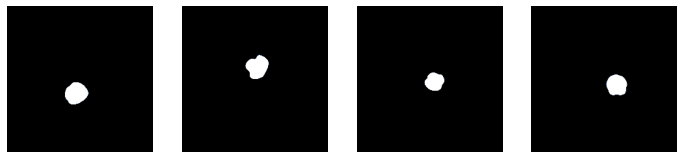

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0044,  0.0214,  0.0204,  ..., -0.0031, -0.0117,  0.0070],
        [-0.0196,  0.0061,  0.0087,  ...,  0.0085, -0.0138,  0.0068]],
       requires_grad=True), Parameter containing:
tensor([0.0176, 0.0045], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7810 Acc: 0.4922
val Loss: 0.8068 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6908 Acc: 0.5156
val Loss: 0.7019 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6703 Acc: 0.5391
val Loss: 0.6926 Acc: 0.5000

Epoch 30/499
----------
train Loss: 0.6951 Acc: 0.5469
val Loss: 0.6825 Acc: 0.5625

Epoch 40/499
----------
train Loss: 0.6878 Acc: 0.5703
val Loss: 0.6827 Acc: 0.6250

Epoch 50/499
----------
train Loss: 0.6567 Acc: 0.6328
val Loss: 0.6865 Acc: 0.5000

Epoch 60/499
----------
train Loss: 0.7067 Acc: 0.5625
val Loss: 0.6080 Acc: 0.7188

Epoch 70/499
----------
train Loss: 0.6769 Acc: 0.5859
val Loss: 0.6759 Acc: 0.5312

Epoch 80/499
----------
train Loss: 0.6668

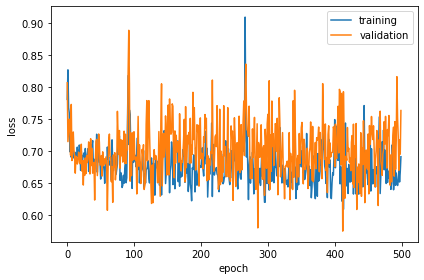

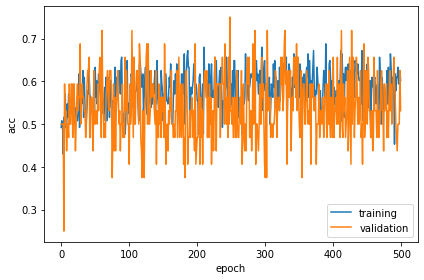

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


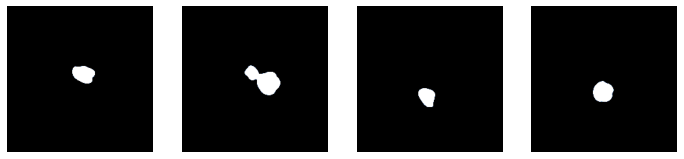

['weight', 'bias']
[Parameter containing:
tensor([[-0.0087, -0.0144,  0.0175,  ...,  0.0182,  0.0170, -0.0005],
        [-0.0015, -0.0147, -0.0149,  ...,  0.0118,  0.0158, -0.0039]],
       requires_grad=True), Parameter containing:
tensor([ 0.0071, -0.0200], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7823 Acc: 0.4453
val Loss: 0.6954 Acc: 0.3750

Epoch 10/499
----------
train Loss: 0.6796 Acc: 0.6016
val Loss: 0.7036 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6901 Acc: 0.5156
val Loss: 0.7220 Acc: 0.5000

Epoch 30/499
----------
train Loss: 0.6286 Acc: 0.6562
val Loss: 0.7680 Acc: 0.4375

Epoch 40/499
----------
train Loss: 0.6406 Acc: 0.6641
val Loss: 0.7527 Acc: 0.4062

Epoch 50/499
----------
train Loss: 0.6567 Acc: 0.5859
val Loss: 0.6878 Acc: 0.5625

Epoch 60/499
----------
train Loss: 0.6708 Acc: 0.5938
val Loss: 0.7355 Acc: 0.4375

Epoch 70/499
----------
train Loss: 0.6517 Acc: 0.6406
val Loss: 0.6917 Acc: 0.5312

Epoch 80/499
----------
train Loss: 0.65

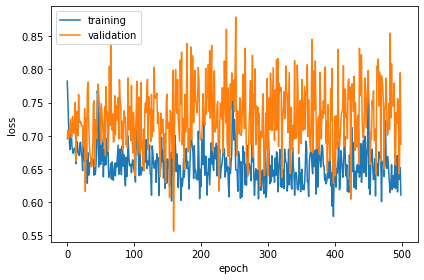

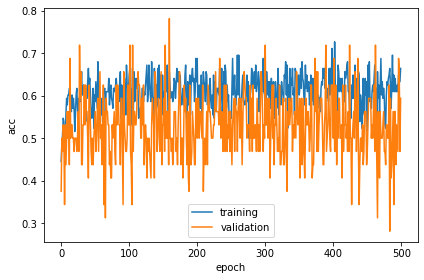

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


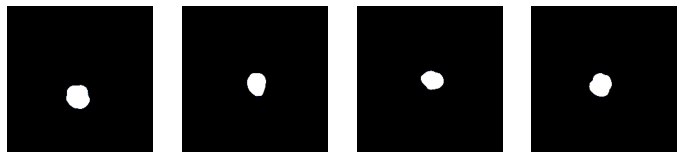

['weight', 'bias']
[Parameter containing:
tensor([[-0.0084,  0.0033,  0.0001,  ...,  0.0186,  0.0046, -0.0141],
        [-0.0052,  0.0211, -0.0087,  ...,  0.0035, -0.0027, -0.0176]],
       requires_grad=True), Parameter containing:
tensor([-0.0009, -0.0175], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7671 Acc: 0.4766
val Loss: 0.7086 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6723 Acc: 0.5625
val Loss: 0.6948 Acc: 0.5625

Epoch 20/499
----------
train Loss: 0.6861 Acc: 0.6016
val Loss: 0.7258 Acc: 0.5000

Epoch 30/499
----------
train Loss: 0.6450 Acc: 0.6016
val Loss: 0.6382 Acc: 0.6250

Epoch 40/499
----------
train Loss: 0.6553 Acc: 0.6172
val Loss: 0.6979 Acc: 0.6250

Epoch 50/499
----------
train Loss: 0.6749 Acc: 0.5859
val Loss: 0.6954 Acc: 0.5625

Epoch 60/499
----------
train Loss: 0.6716 Acc: 0.6016
val Loss: 0.7012 Acc: 0.5938

Epoch 70/499
----------
train Loss: 0.6383 Acc: 0.6328
val Loss: 0.6537 Acc: 0.5312

Epoch 80/499
----------
train Loss: 0.69

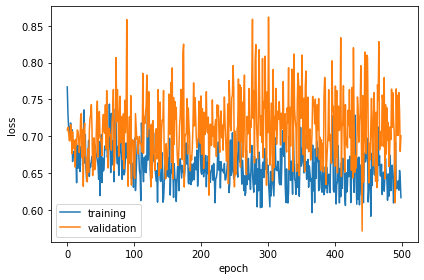

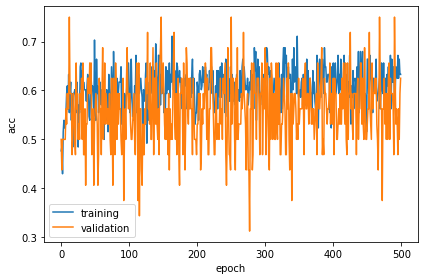

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1
 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


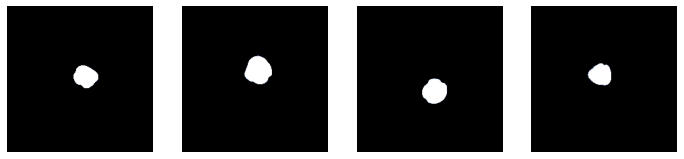

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0108,  0.0074, -0.0211,  ..., -0.0075, -0.0079,  0.0161],
        [ 0.0025, -0.0107,  0.0029,  ..., -0.0198, -0.0051, -0.0149]],
       requires_grad=True), Parameter containing:
tensor([-0.0054,  0.0187], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7400 Acc: 0.5234
val Loss: 0.7234 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.7051 Acc: 0.5156
val Loss: 0.6747 Acc: 0.5938

Epoch 20/499
----------
train Loss: 0.6523 Acc: 0.5703
val Loss: 0.7927 Acc: 0.5000

Epoch 30/499
----------
train Loss: 0.6793 Acc: 0.5547
val Loss: 0.6919 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.6608 Acc: 0.5781
val Loss: 0.7783 Acc: 0.3750

Epoch 50/499
----------
train Loss: 0.6602 Acc: 0.6328
val Loss: 0.6332 Acc: 0.5625

Epoch 60/499
----------
train Loss: 0.6997 Acc: 0.5156
val Loss: 0.7039 Acc: 0.5625

Epoch 70/499
----------
train Loss: 0.6904 Acc: 0.5312
val Loss: 0.6561 Acc: 0.6562

Epoch 80/499
----------
train Loss: 0.69

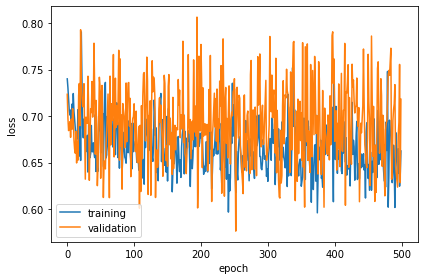

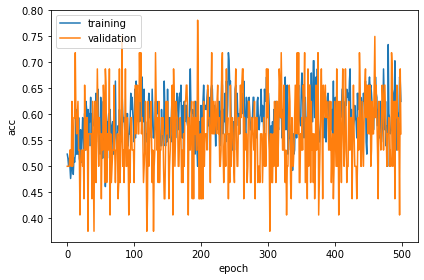

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0
 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


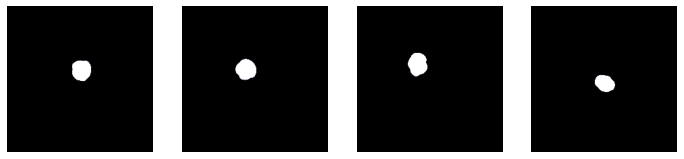

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0135, -0.0081,  0.0133,  ..., -0.0087, -0.0156, -0.0157],
        [-0.0110,  0.0191, -0.0156,  ..., -0.0202, -0.0083,  0.0130]],
       requires_grad=True), Parameter containing:
tensor([0.0069, 0.0039], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7976 Acc: 0.4922
val Loss: 0.7103 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6835 Acc: 0.5781
val Loss: 0.6909 Acc: 0.4688

Epoch 20/499
----------
train Loss: 0.6913 Acc: 0.5859
val Loss: 0.6707 Acc: 0.5938

Epoch 30/499
----------
train Loss: 0.6748 Acc: 0.5859
val Loss: 0.6809 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.6616 Acc: 0.5859
val Loss: 0.6788 Acc: 0.5625

Epoch 50/499
----------
train Loss: 0.6875 Acc: 0.5234
val Loss: 0.7126 Acc: 0.4688

Epoch 60/499
----------
train Loss: 0.6452 Acc: 0.6328
val Loss: 0.6658 Acc: 0.5312

Epoch 70/499
----------
train Loss: 0.7055 Acc: 0.5859
val Loss: 0.6840 Acc: 0.6562

Epoch 80/499
----------
train Loss: 0.6724

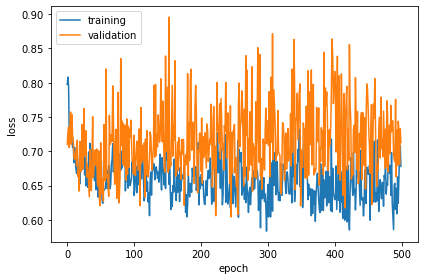

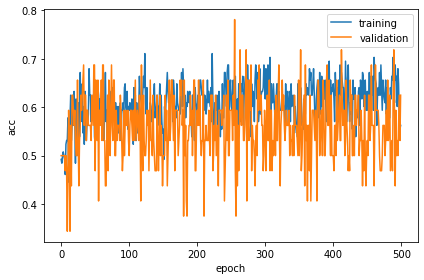

{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/Aus/1d'}
Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_mask/Aus/1d
{'Aus_1d_F': 0, 'Aus_1d_M': 1}
{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


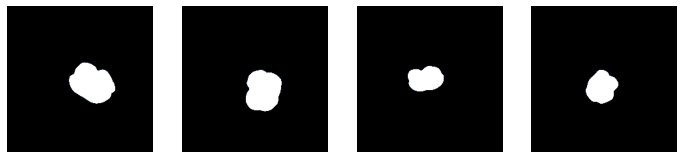

['weight', 'bias']
[Parameter containing:
tensor([[-0.0183, -0.0041, -0.0014,  ...,  0.0027,  0.0164,  0.0134],
        [-0.0123,  0.0023,  0.0018,  ...,  0.0121, -0.0193, -0.0035]],
       requires_grad=True), Parameter containing:
tensor([-0.0202, -0.0005], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7364 Acc: 0.5312
val Loss: 0.6983 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6958 Acc: 0.5312
val Loss: 0.6952 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.7003 Acc: 0.4844
val Loss: 0.7094 Acc: 0.4688

Epoch 30/499
----------
train Loss: 0.6805 Acc: 0.6172
val Loss: 0.7204 Acc: 0.5000

Epoch 40/499
----------
train Loss: 0.7056 Acc: 0.5234
val Loss: 0.7023 Acc: 0.5625

Epoch 50/499
----------
train Loss: 0.6960 Acc: 0.5938
val Loss: 0.6663 Acc: 0.6250

Epoch 60/499
----------
train Loss: 0.6519 Acc: 0.5859
val Loss: 0.8258 Acc: 0.2812

Epoch 70/499
----------
train Loss: 0.6989 Acc: 0.5391
val Loss: 0.7056 Acc: 0.5625

Epoch 80/499
----------
train Loss: 0.70

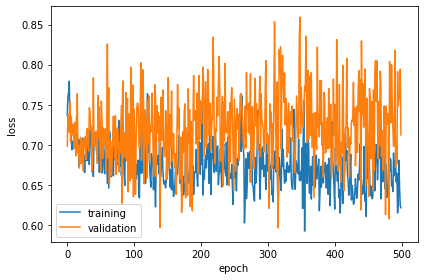

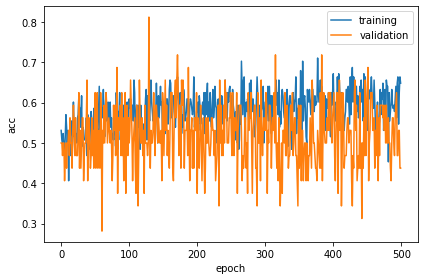

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


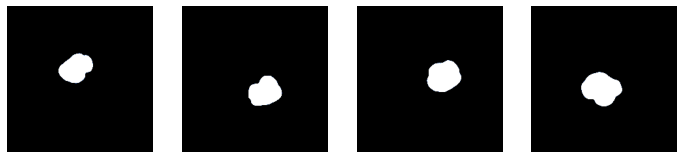

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0151,  0.0193, -0.0183,  ...,  0.0071,  0.0027, -0.0137],
        [-0.0140, -0.0124, -0.0213,  ..., -0.0164, -0.0188,  0.0042]],
       requires_grad=True), Parameter containing:
tensor([0.0014, 0.0117], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7478 Acc: 0.5234
val Loss: 0.8125 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6456 Acc: 0.6797
val Loss: 0.7210 Acc: 0.5312

Epoch 20/499
----------
train Loss: 0.6887 Acc: 0.5625
val Loss: 0.6724 Acc: 0.5625

Epoch 30/499
----------
train Loss: 0.6707 Acc: 0.6016
val Loss: 0.7750 Acc: 0.5312

Epoch 40/499
----------
train Loss: 0.6937 Acc: 0.5234
val Loss: 0.6921 Acc: 0.4688

Epoch 50/499
----------
train Loss: 0.6472 Acc: 0.6406
val Loss: 0.7328 Acc: 0.5625

Epoch 60/499
----------
train Loss: 0.6542 Acc: 0.6094
val Loss: 0.6969 Acc: 0.5000

Epoch 70/499
----------
train Loss: 0.6832 Acc: 0.6250
val Loss: 0.7220 Acc: 0.5938

Epoch 80/499
----------
train Loss: 0.6485

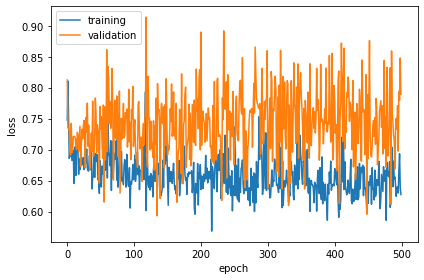

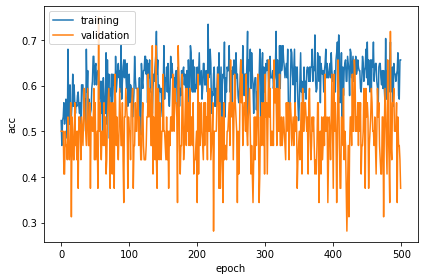

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


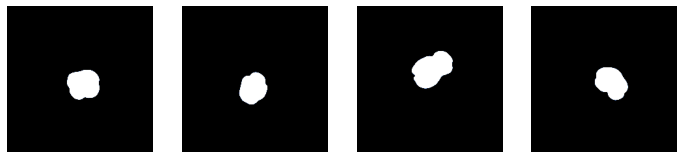

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0159,  0.0043,  0.0078,  ..., -0.0008, -0.0005, -0.0005],
        [ 0.0146, -0.0148,  0.0051,  ...,  0.0155,  0.0152, -0.0027]],
       requires_grad=True), Parameter containing:
tensor([-0.0148, -0.0060], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7899 Acc: 0.4609
val Loss: 0.7469 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.7080 Acc: 0.4844
val Loss: 0.6991 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6646 Acc: 0.5625
val Loss: 0.6498 Acc: 0.6562

Epoch 30/499
----------
train Loss: 0.6741 Acc: 0.5859
val Loss: 0.6901 Acc: 0.5000

Epoch 40/499
----------
train Loss: 0.6862 Acc: 0.5703
val Loss: 0.7086 Acc: 0.5312

Epoch 50/499
----------
train Loss: 0.7226 Acc: 0.5391
val Loss: 0.6814 Acc: 0.5625

Epoch 60/499
----------
train Loss: 0.7055 Acc: 0.5312
val Loss: 0.6779 Acc: 0.5938

Epoch 70/499
----------
train Loss: 0.7053 Acc: 0.5312
val Loss: 0.6330 Acc: 0.6562

Epoch 80/499
----------
train Loss: 0.69

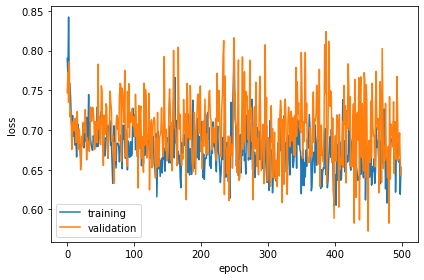

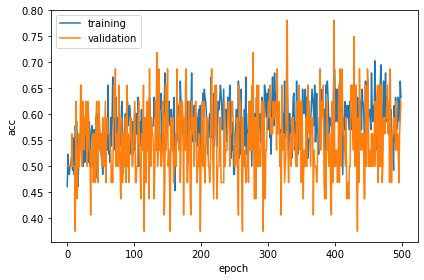

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1
 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


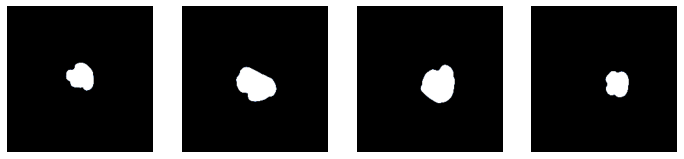

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0081,  0.0207, -0.0102,  ...,  0.0021, -0.0151,  0.0155],
        [ 0.0071, -0.0203, -0.0102,  ...,  0.0099,  0.0037, -0.0072]],
       requires_grad=True), Parameter containing:
tensor([-0.0113,  0.0051], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.8182 Acc: 0.4141
val Loss: 0.7303 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6866 Acc: 0.5469
val Loss: 0.6970 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6698 Acc: 0.5781
val Loss: 0.6944 Acc: 0.5625

Epoch 30/499
----------
train Loss: 0.6581 Acc: 0.6250
val Loss: 0.6769 Acc: 0.6250

Epoch 40/499
----------
train Loss: 0.6593 Acc: 0.5859
val Loss: 0.7215 Acc: 0.5312

Epoch 50/499
----------
train Loss: 0.6648 Acc: 0.5547
val Loss: 0.7100 Acc: 0.5312

Epoch 60/499
----------
train Loss: 0.6483 Acc: 0.6328
val Loss: 0.7778 Acc: 0.3438

Epoch 70/499
----------
train Loss: 0.6922 Acc: 0.5625
val Loss: 0.7355 Acc: 0.4375

Epoch 80/499
----------
train Loss: 0.66

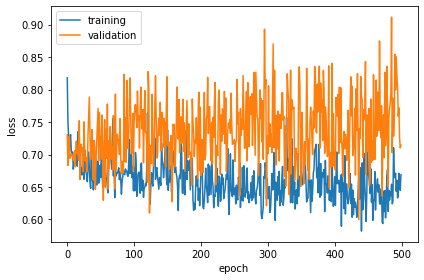

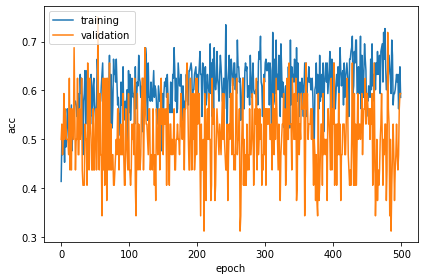

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0
 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


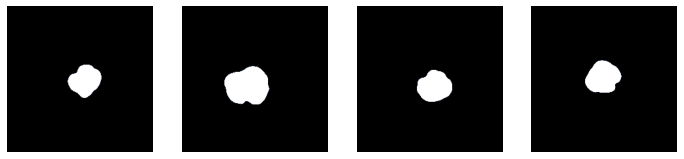

['weight', 'bias']
[Parameter containing:
tensor([[-0.0055, -0.0084,  0.0047,  ...,  0.0090, -0.0072,  0.0137],
        [-0.0188, -0.0022,  0.0040,  ..., -0.0103, -0.0115,  0.0025]],
       requires_grad=True), Parameter containing:
tensor([0.0056, 0.0112], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7078 Acc: 0.6172
val Loss: 0.6954 Acc: 0.5625

Epoch 10/499
----------
train Loss: 0.6878 Acc: 0.5781
val Loss: 0.7341 Acc: 0.5312

Epoch 20/499
----------
train Loss: 0.7158 Acc: 0.5312
val Loss: 0.6771 Acc: 0.5625

Epoch 30/499
----------
train Loss: 0.7052 Acc: 0.5000
val Loss: 0.7487 Acc: 0.5625

Epoch 40/499
----------
train Loss: 0.6645 Acc: 0.6250
val Loss: 0.7564 Acc: 0.4688

Epoch 50/499
----------
train Loss: 0.6652 Acc: 0.6016
val Loss: 0.7528 Acc: 0.5312

Epoch 60/499
----------
train Loss: 0.6214 Acc: 0.6719
val Loss: 0.7197 Acc: 0.6250

Epoch 70/499
----------
train Loss: 0.7206 Acc: 0.5156
val Loss: 0.7985 Acc: 0.4688

Epoch 80/499
----------
train Loss: 0.7039

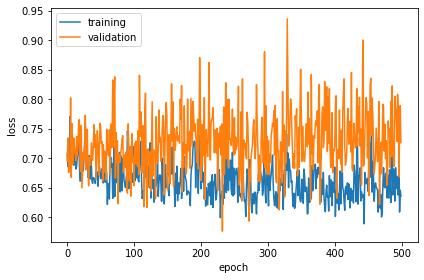

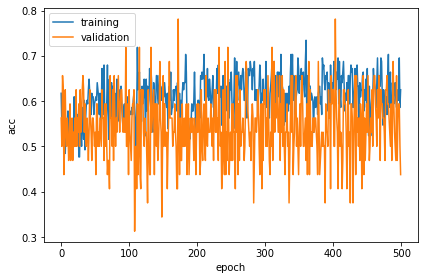

{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/Aus/2d'}
Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_mask/Aus/2d
{'Aus_2d_F': 0, 'Aus_2d_M': 1}
{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


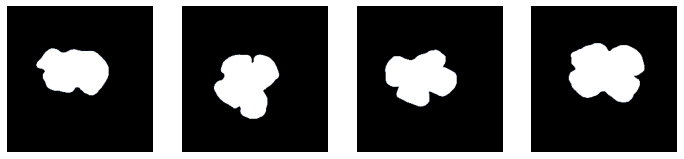

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0218,  0.0004,  0.0119,  ..., -0.0078,  0.0200,  0.0201],
        [-0.0104, -0.0076, -0.0115,  ..., -0.0092,  0.0047, -0.0014]],
       requires_grad=True), Parameter containing:
tensor([0.0194, 0.0141], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7386 Acc: 0.5156
val Loss: 0.7517 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6453 Acc: 0.6562
val Loss: 0.6740 Acc: 0.5938

Epoch 20/499
----------
train Loss: 0.6445 Acc: 0.6250
val Loss: 0.6881 Acc: 0.5625

Epoch 30/499
----------
train Loss: 0.6127 Acc: 0.6328
val Loss: 0.6677 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.5938 Acc: 0.6875
val Loss: 0.6292 Acc: 0.5000

Epoch 50/499
----------
train Loss: 0.6560 Acc: 0.6328
val Loss: 0.5962 Acc: 0.6562

Epoch 60/499
----------
train Loss: 0.5996 Acc: 0.6797
val Loss: 0.7033 Acc: 0.6250

Epoch 70/499
----------
train Loss: 0.5846 Acc: 0.7109
val Loss: 0.5671 Acc: 0.7500

Epoch 80/499
----------
train Loss: 0.5384

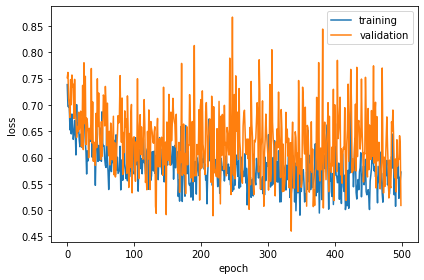

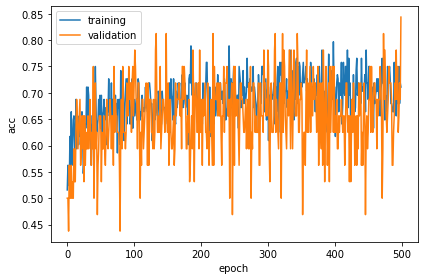

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


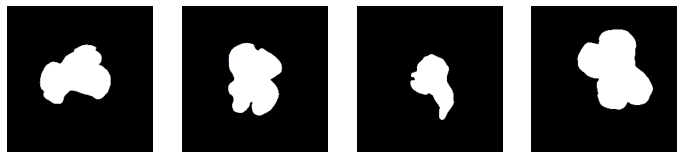

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0018,  0.0072,  0.0021,  ...,  0.0073,  0.0218, -0.0053],
        [-0.0206,  0.0211,  0.0181,  ..., -0.0055, -0.0157,  0.0042]],
       requires_grad=True), Parameter containing:
tensor([-0.0100, -0.0110], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7668 Acc: 0.5078
val Loss: 0.7776 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6450 Acc: 0.6172
val Loss: 0.6838 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6051 Acc: 0.6094
val Loss: 0.7092 Acc: 0.6250

Epoch 30/499
----------
train Loss: 0.6399 Acc: 0.6250
val Loss: 0.6865 Acc: 0.6562

Epoch 40/499
----------
train Loss: 0.6439 Acc: 0.6172
val Loss: 0.6485 Acc: 0.6562

Epoch 50/499
----------
train Loss: 0.6014 Acc: 0.7031
val Loss: 0.7442 Acc: 0.5312

Epoch 60/499
----------
train Loss: 0.5753 Acc: 0.6875
val Loss: 0.7372 Acc: 0.5938

Epoch 70/499
----------
train Loss: 0.5954 Acc: 0.6797
val Loss: 0.7513 Acc: 0.6250

Epoch 80/499
----------
train Loss: 0.59

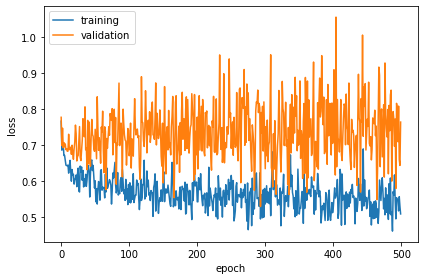

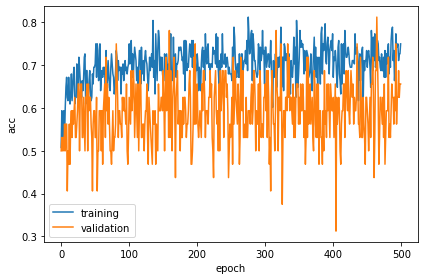

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


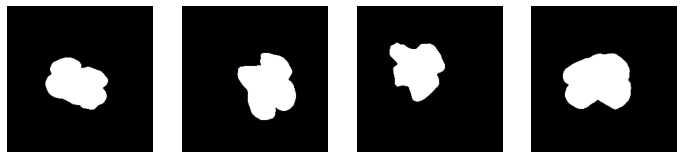

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0051, -0.0217, -0.0132,  ..., -0.0008,  0.0216, -0.0184],
        [-0.0098, -0.0164,  0.0088,  ...,  0.0157,  0.0148,  0.0021]],
       requires_grad=True), Parameter containing:
tensor([ 0.0075, -0.0180], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7779 Acc: 0.4922
val Loss: 0.7058 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6477 Acc: 0.6094
val Loss: 0.6901 Acc: 0.5625

Epoch 20/499
----------
train Loss: 0.6411 Acc: 0.6250
val Loss: 0.6713 Acc: 0.6250

Epoch 30/499
----------
train Loss: 0.6360 Acc: 0.6484
val Loss: 0.7349 Acc: 0.5625

Epoch 40/499
----------
train Loss: 0.6191 Acc: 0.6250
val Loss: 0.6810 Acc: 0.6250

Epoch 50/499
----------
train Loss: 0.6182 Acc: 0.6641
val Loss: 0.5886 Acc: 0.6875

Epoch 60/499
----------
train Loss: 0.6279 Acc: 0.6484
val Loss: 0.6244 Acc: 0.7500

Epoch 70/499
----------
train Loss: 0.5844 Acc: 0.6875
val Loss: 0.6403 Acc: 0.5938

Epoch 80/499
----------
train Loss: 0.60

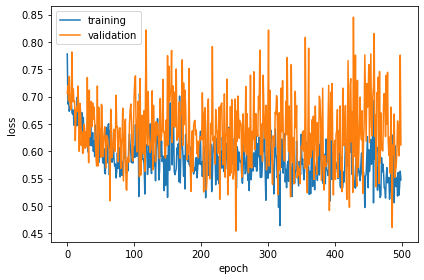

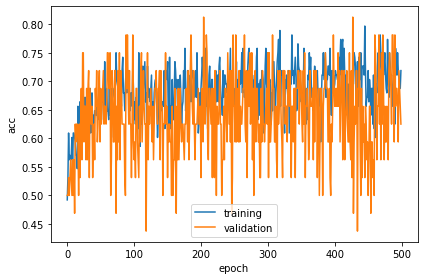

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1
 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


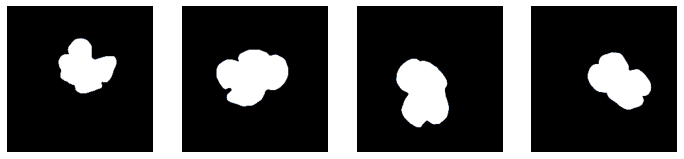

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0199, -0.0090,  0.0082,  ...,  0.0216, -0.0154, -0.0116],
        [-0.0190, -0.0171,  0.0100,  ..., -0.0112,  0.0145, -0.0082]],
       requires_grad=True), Parameter containing:
tensor([0.0098, 0.0166], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7747 Acc: 0.4844
val Loss: 0.7038 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6564 Acc: 0.5859
val Loss: 0.7131 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6105 Acc: 0.6641
val Loss: 0.6545 Acc: 0.6562

Epoch 30/499
----------
train Loss: 0.5869 Acc: 0.7266
val Loss: 0.6289 Acc: 0.6250

Epoch 40/499
----------
train Loss: 0.6502 Acc: 0.5781
val Loss: 0.5978 Acc: 0.7188

Epoch 50/499
----------
train Loss: 0.5714 Acc: 0.6797
val Loss: 0.5529 Acc: 0.7812

Epoch 60/499
----------
train Loss: 0.5744 Acc: 0.6641
val Loss: 0.6299 Acc: 0.5312

Epoch 70/499
----------
train Loss: 0.6472 Acc: 0.6094
val Loss: 0.5781 Acc: 0.6875

Epoch 80/499
----------
train Loss: 0.6475

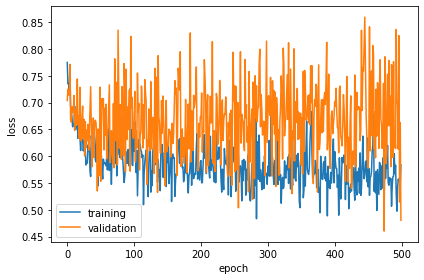

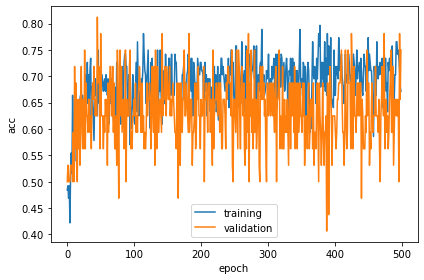

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0
 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


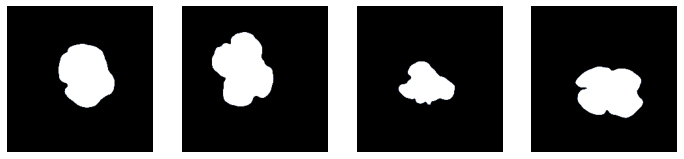

['weight', 'bias']
[Parameter containing:
tensor([[-0.0210,  0.0091, -0.0138,  ...,  0.0155,  0.0120,  0.0176],
        [-0.0197,  0.0089,  0.0039,  ..., -0.0196,  0.0220,  0.0070]],
       requires_grad=True), Parameter containing:
tensor([0.0006, 0.0168], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.8805 Acc: 0.5234
val Loss: 0.7701 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6740 Acc: 0.5859
val Loss: 0.6846 Acc: 0.4688

Epoch 20/499
----------
train Loss: 0.6427 Acc: 0.6406
val Loss: 0.5979 Acc: 0.7500

Epoch 30/499
----------
train Loss: 0.6534 Acc: 0.5938
val Loss: 0.6621 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.5956 Acc: 0.6875
val Loss: 0.7254 Acc: 0.6250

Epoch 50/499
----------
train Loss: 0.6158 Acc: 0.6641
val Loss: 0.6515 Acc: 0.5938

Epoch 60/499
----------
train Loss: 0.5835 Acc: 0.6875
val Loss: 0.6083 Acc: 0.6250

Epoch 70/499
----------
train Loss: 0.5699 Acc: 0.7188
val Loss: 0.6165 Acc: 0.5938

Epoch 80/499
----------
train Loss: 0.5597

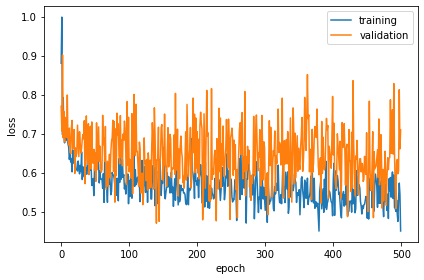

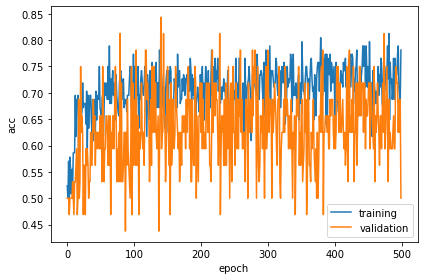

{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/Aus/3d'}
Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_mask/Aus/3d
{'Aus_3d_F': 0, 'Aus_3d_M': 1}
{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


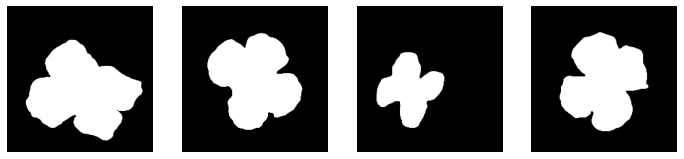

['weight', 'bias']
[Parameter containing:
tensor([[-0.0158, -0.0161,  0.0022,  ..., -0.0054,  0.0143,  0.0194],
        [-0.0185,  0.0158, -0.0206,  ..., -0.0106, -0.0062, -0.0151]],
       requires_grad=True), Parameter containing:
tensor([ 0.0203, -0.0167], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7661 Acc: 0.5312
val Loss: 0.7577 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6664 Acc: 0.6016
val Loss: 0.6922 Acc: 0.4688

Epoch 20/499
----------
train Loss: 0.6429 Acc: 0.6250
val Loss: 0.6798 Acc: 0.6250

Epoch 30/499
----------
train Loss: 0.6429 Acc: 0.6562
val Loss: 0.6274 Acc: 0.6250

Epoch 40/499
----------
train Loss: 0.6332 Acc: 0.6562
val Loss: 0.6804 Acc: 0.6250

Epoch 50/499
----------
train Loss: 0.6005 Acc: 0.6797
val Loss: 0.6694 Acc: 0.5625

Epoch 60/499
----------
train Loss: 0.6210 Acc: 0.6641
val Loss: 0.6523 Acc: 0.5938

Epoch 70/499
----------
train Loss: 0.6125 Acc: 0.6484
val Loss: 0.6776 Acc: 0.5625

Epoch 80/499
----------
train Loss: 0.62

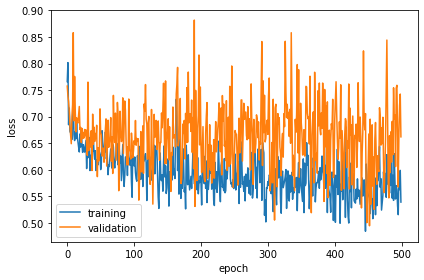

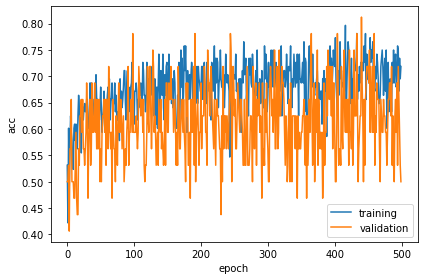

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


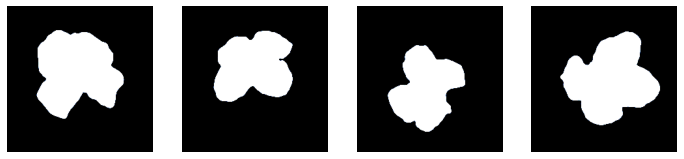

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0177,  0.0177,  0.0075,  ..., -0.0040, -0.0025,  0.0117],
        [-0.0071,  0.0099,  0.0102,  ..., -0.0008, -0.0020,  0.0206]],
       requires_grad=True), Parameter containing:
tensor([0.0046, 0.0010], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7358 Acc: 0.5078
val Loss: 0.7670 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6277 Acc: 0.6406
val Loss: 0.6930 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.5713 Acc: 0.6875
val Loss: 0.7713 Acc: 0.5000

Epoch 30/499
----------
train Loss: 0.5720 Acc: 0.6875
val Loss: 0.7994 Acc: 0.5312

Epoch 40/499
----------
train Loss: 0.5385 Acc: 0.7422
val Loss: 0.6196 Acc: 0.6875

Epoch 50/499
----------
train Loss: 0.5688 Acc: 0.6797
val Loss: 0.7649 Acc: 0.5000

Epoch 60/499
----------
train Loss: 0.5373 Acc: 0.7500
val Loss: 0.6114 Acc: 0.6562

Epoch 70/499
----------
train Loss: 0.5077 Acc: 0.7188
val Loss: 0.7574 Acc: 0.5312

Epoch 80/499
----------
train Loss: 0.5143

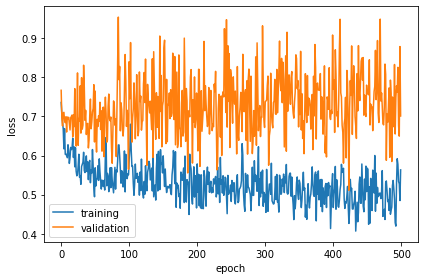

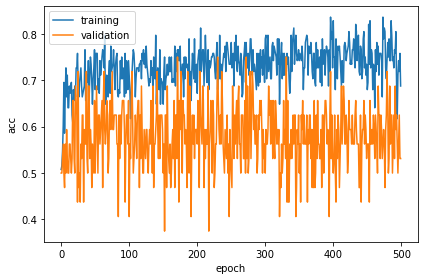

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


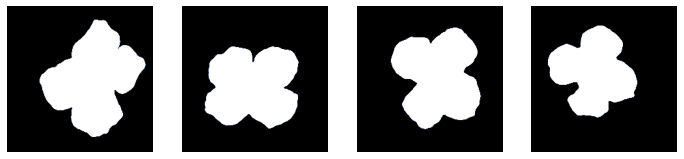

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0192,  0.0152,  0.0139,  ..., -0.0156, -0.0215,  0.0031],
        [ 0.0180, -0.0105,  0.0147,  ...,  0.0106,  0.0150,  0.0194]],
       requires_grad=True), Parameter containing:
tensor([ 0.0206, -0.0125], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7574 Acc: 0.5234
val Loss: 0.8513 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.7013 Acc: 0.5391
val Loss: 0.7510 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6144 Acc: 0.6719
val Loss: 0.6057 Acc: 0.6250

Epoch 30/499
----------
train Loss: 0.6261 Acc: 0.6328
val Loss: 0.6678 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.6354 Acc: 0.6250
val Loss: 0.7180 Acc: 0.5625

Epoch 50/499
----------
train Loss: 0.5964 Acc: 0.7109
val Loss: 0.7453 Acc: 0.5312

Epoch 60/499
----------
train Loss: 0.6042 Acc: 0.6875
val Loss: 0.5245 Acc: 0.8125

Epoch 70/499
----------
train Loss: 0.6227 Acc: 0.6016
val Loss: 0.6810 Acc: 0.6250

Epoch 80/499
----------
train Loss: 0.61

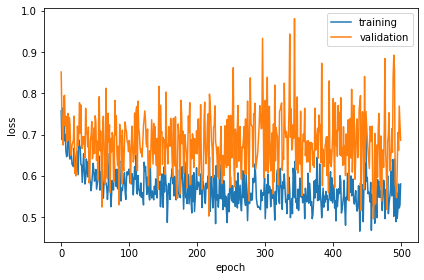

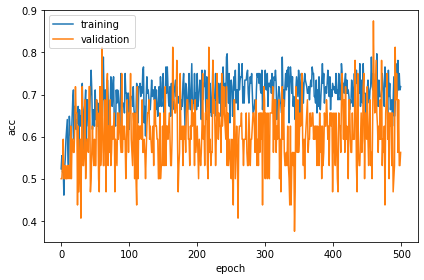

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1
 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


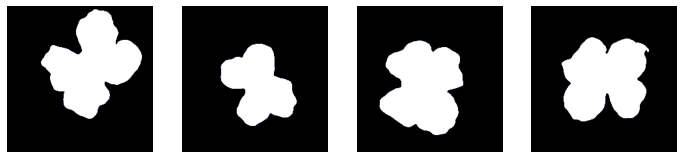

['weight', 'bias']
[Parameter containing:
tensor([[-0.0131, -0.0028, -0.0052,  ...,  0.0202, -0.0179,  0.0036],
        [-0.0134,  0.0059,  0.0198,  ...,  0.0105, -0.0086, -0.0097]],
       requires_grad=True), Parameter containing:
tensor([ 0.0040, -0.0151], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7406 Acc: 0.5391
val Loss: 0.7981 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.5964 Acc: 0.7031
val Loss: 0.6909 Acc: 0.5938

Epoch 20/499
----------
train Loss: 0.6163 Acc: 0.6250
val Loss: 0.7239 Acc: 0.5625

Epoch 30/499
----------
train Loss: 0.5517 Acc: 0.7422
val Loss: 0.7350 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.5648 Acc: 0.7031
val Loss: 0.7644 Acc: 0.5938

Epoch 50/499
----------
train Loss: 0.5689 Acc: 0.7031
val Loss: 0.7169 Acc: 0.6250

Epoch 60/499
----------
train Loss: 0.5143 Acc: 0.7734
val Loss: 0.8183 Acc: 0.5938

Epoch 70/499
----------
train Loss: 0.5354 Acc: 0.7812
val Loss: 0.8042 Acc: 0.5938

Epoch 80/499
----------
train Loss: 0.58

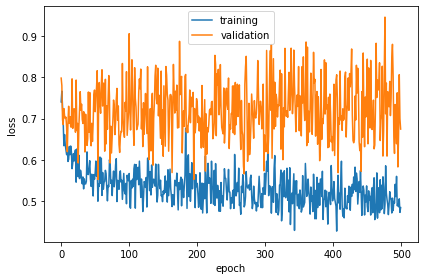

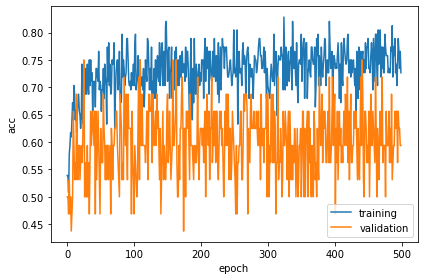

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0
 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


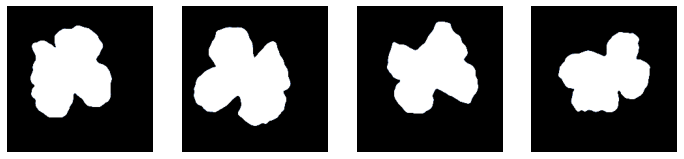

['weight', 'bias']
[Parameter containing:
tensor([[-0.0004, -0.0031,  0.0122,  ..., -0.0067, -0.0051, -0.0215],
        [ 0.0063, -0.0036, -0.0058,  ...,  0.0024, -0.0157, -0.0171]],
       requires_grad=True), Parameter containing:
tensor([-0.0216, -0.0201], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7148 Acc: 0.5859
val Loss: 0.7935 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6330 Acc: 0.6172
val Loss: 0.7003 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6280 Acc: 0.6094
val Loss: 0.7547 Acc: 0.4688

Epoch 30/499
----------
train Loss: 0.5633 Acc: 0.7188
val Loss: 0.6957 Acc: 0.5938

Epoch 40/499
----------
train Loss: 0.5964 Acc: 0.6953
val Loss: 0.7097 Acc: 0.5312

Epoch 50/499
----------
train Loss: 0.5905 Acc: 0.7188
val Loss: 0.7578 Acc: 0.5312

Epoch 60/499
----------
train Loss: 0.5683 Acc: 0.6562
val Loss: 0.7210 Acc: 0.5312

Epoch 70/499
----------
train Loss: 0.5218 Acc: 0.7734
val Loss: 0.7294 Acc: 0.5938

Epoch 80/499
----------
train Loss: 0.57

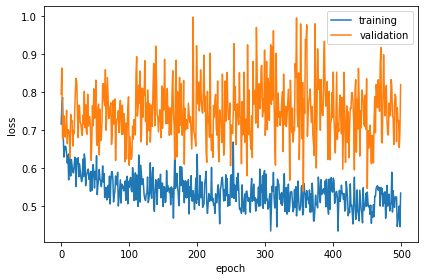

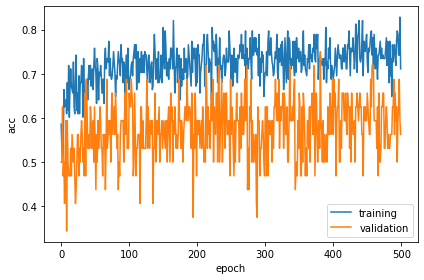

{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/Aus/4d'}
Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./data/data_mask/Aus/4d
{'Aus_4d_F': 0, 'Aus_4d_M': 1}
{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


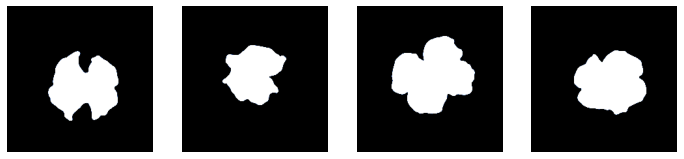

['weight', 'bias']
[Parameter containing:
tensor([[-0.0151,  0.0105,  0.0212,  ..., -0.0086,  0.0026, -0.0176],
        [ 0.0216, -0.0084, -0.0067,  ..., -0.0068, -0.0134, -0.0072]],
       requires_grad=True), Parameter containing:
tensor([0.0118, 0.0138], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7924 Acc: 0.4766
val Loss: 0.7194 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.5335 Acc: 0.7266
val Loss: 0.5893 Acc: 0.6250

Epoch 20/499
----------
train Loss: 0.5217 Acc: 0.7422
val Loss: 0.5493 Acc: 0.7188

Epoch 30/499
----------
train Loss: 0.5299 Acc: 0.7266
val Loss: 0.5105 Acc: 0.7500

Epoch 40/499
----------
train Loss: 0.5202 Acc: 0.6953
val Loss: 0.4256 Acc: 0.8438

Epoch 50/499
----------
train Loss: 0.4837 Acc: 0.7500
val Loss: 0.4282 Acc: 0.8125

Epoch 60/499
----------
train Loss: 0.4928 Acc: 0.7734
val Loss: 0.4661 Acc: 0.7812

Epoch 70/499
----------
train Loss: 0.5311 Acc: 0.6953
val Loss: 0.4241 Acc: 0.8125

Epoch 80/499
----------
train Loss: 0.4834

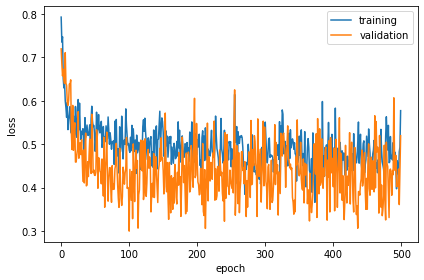

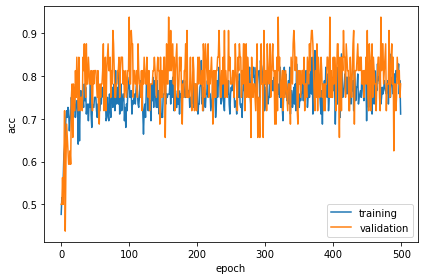

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


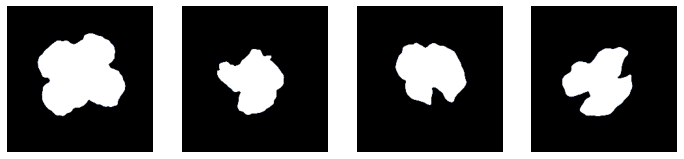

['weight', 'bias']
[Parameter containing:
tensor([[-0.0068,  0.0151, -0.0065,  ..., -0.0140,  0.0071, -0.0081],
        [-0.0058,  0.0209,  0.0119,  ..., -0.0166, -0.0007,  0.0128]],
       requires_grad=True), Parameter containing:
tensor([ 0.0069, -0.0186], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7421 Acc: 0.5312
val Loss: 0.8484 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.5018 Acc: 0.7734
val Loss: 0.6433 Acc: 0.6875

Epoch 20/499
----------
train Loss: 0.4697 Acc: 0.7812
val Loss: 0.6565 Acc: 0.6250

Epoch 30/499
----------
train Loss: 0.4318 Acc: 0.8438
val Loss: 0.5110 Acc: 0.6875

Epoch 40/499
----------
train Loss: 0.4583 Acc: 0.7656
val Loss: 0.5983 Acc: 0.6250

Epoch 50/499
----------
train Loss: 0.4894 Acc: 0.7344
val Loss: 0.6976 Acc: 0.6875

Epoch 60/499
----------
train Loss: 0.4297 Acc: 0.7969
val Loss: 0.6234 Acc: 0.6562

Epoch 70/499
----------
train Loss: 0.3821 Acc: 0.8281
val Loss: 0.6207 Acc: 0.6875

Epoch 80/499
----------
train Loss: 0.49

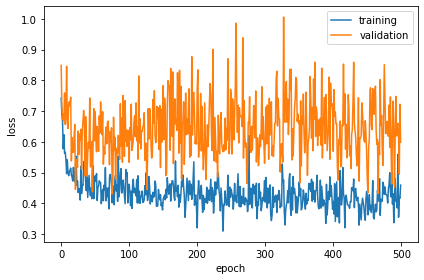

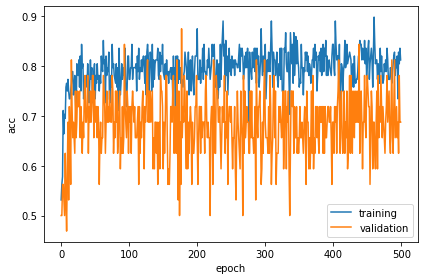

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


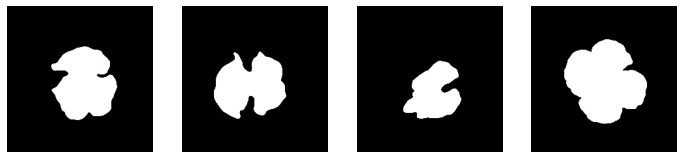

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0195, -0.0027,  0.0103,  ..., -0.0083,  0.0113,  0.0154],
        [-0.0162, -0.0010,  0.0156,  ...,  0.0097,  0.0149,  0.0146]],
       requires_grad=True), Parameter containing:
tensor([-0.0052,  0.0201], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7951 Acc: 0.4531
val Loss: 0.6892 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.5123 Acc: 0.7969
val Loss: 0.6408 Acc: 0.5625

Epoch 20/499
----------
train Loss: 0.5589 Acc: 0.7344
val Loss: 0.4234 Acc: 0.8125

Epoch 30/499
----------
train Loss: 0.5224 Acc: 0.7812
val Loss: 0.5495 Acc: 0.6875

Epoch 40/499
----------
train Loss: 0.5326 Acc: 0.7188
val Loss: 0.5019 Acc: 0.7812

Epoch 50/499
----------
train Loss: 0.4575 Acc: 0.7891
val Loss: 0.3587 Acc: 0.9062

Epoch 60/499
----------
train Loss: 0.5411 Acc: 0.6875
val Loss: 0.3881 Acc: 0.8750

Epoch 70/499
----------
train Loss: 0.4785 Acc: 0.7891
val Loss: 0.6354 Acc: 0.7188

Epoch 80/499
----------
train Loss: 0.47

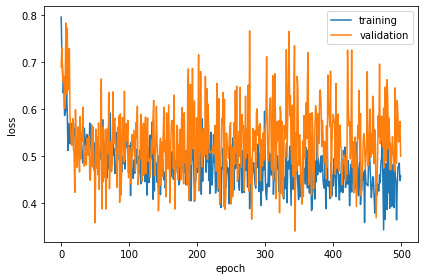

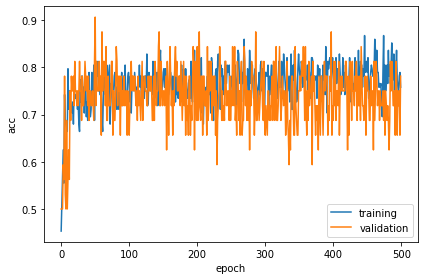

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1
 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


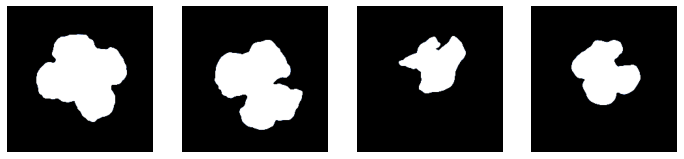

['weight', 'bias']
[Parameter containing:
tensor([[-0.0065, -0.0026,  0.0008,  ...,  0.0159, -0.0150, -0.0014],
        [ 0.0051,  0.0046, -0.0129,  ..., -0.0195, -0.0063, -0.0028]],
       requires_grad=True), Parameter containing:
tensor([ 0.0173, -0.0215], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7323 Acc: 0.5234
val Loss: 0.7711 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.5226 Acc: 0.7734
val Loss: 0.6234 Acc: 0.5938

Epoch 20/499
----------
train Loss: 0.4762 Acc: 0.7812
val Loss: 0.5979 Acc: 0.7188

Epoch 30/499
----------
train Loss: 0.5155 Acc: 0.7422
val Loss: 0.5830 Acc: 0.6875

Epoch 40/499
----------
train Loss: 0.4825 Acc: 0.7266
val Loss: 0.5065 Acc: 0.6875

Epoch 50/499
----------
train Loss: 0.4794 Acc: 0.7578
val Loss: 0.6129 Acc: 0.7188

Epoch 60/499
----------
train Loss: 0.4729 Acc: 0.7656
val Loss: 0.6690 Acc: 0.6875

Epoch 70/499
----------
train Loss: 0.4861 Acc: 0.7578
val Loss: 0.5795 Acc: 0.7188

Epoch 80/499
----------
train Loss: 0.52

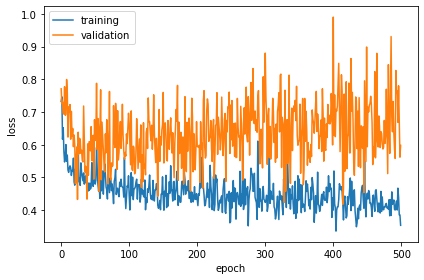

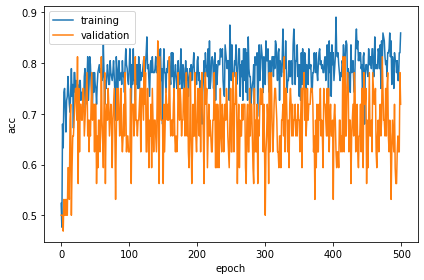

{'n_train': 128, 'n_val': 32, 'n_test': 40}
40
[1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0
 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


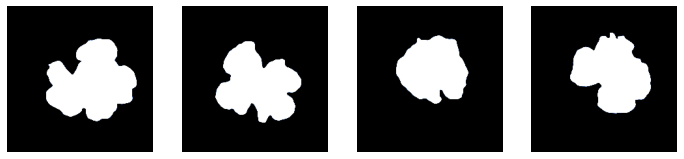

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0198, -0.0013, -0.0152,  ..., -0.0196, -0.0085, -0.0209],
        [ 0.0217, -0.0051, -0.0208,  ...,  0.0159,  0.0057, -0.0089]],
       requires_grad=True), Parameter containing:
tensor([ 0.0066, -0.0109], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7934 Acc: 0.4766
val Loss: 0.8868 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.5223 Acc: 0.7422
val Loss: 0.6599 Acc: 0.6250

Epoch 20/499
----------
train Loss: 0.4951 Acc: 0.7734
val Loss: 0.6027 Acc: 0.6875

Epoch 30/499
----------
train Loss: 0.4670 Acc: 0.7969
val Loss: 0.5451 Acc: 0.6875

Epoch 40/499
----------
train Loss: 0.4590 Acc: 0.7422
val Loss: 0.6369 Acc: 0.6562

Epoch 50/499
----------
train Loss: 0.4628 Acc: 0.7891
val Loss: 0.5747 Acc: 0.6562

Epoch 60/499
----------
train Loss: 0.5645 Acc: 0.7031
val Loss: 0.5946 Acc: 0.6875

Epoch 70/499
----------
train Loss: 0.4501 Acc: 0.7891
val Loss: 0.4927 Acc: 0.7812

Epoch 80/499
----------
train Loss: 0.54

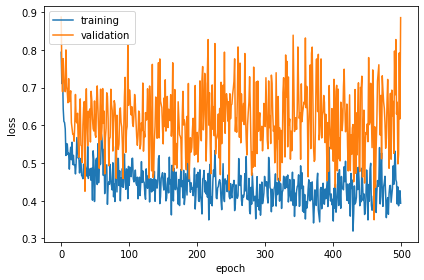

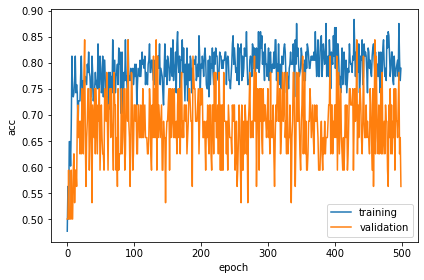

{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/Aus/7d'}
Dataset ImageFolder
    Number of datapoints: 199
    Root location: ./data/data_mask/Aus/7d
{'Aus_7d_F': 0, 'Aus_7d_M': 1}
{'n_train': 127, 'n_val': 32, 'n_test': 40}
40
[0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 0 0
 0 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


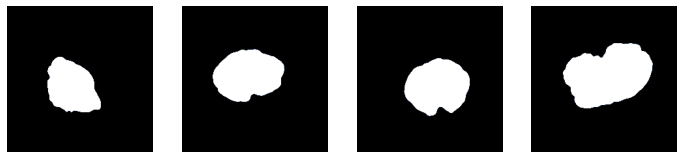

['weight', 'bias']
[Parameter containing:
tensor([[-0.0115,  0.0201,  0.0093,  ...,  0.0209,  0.0017, -0.0209],
        [ 0.0178,  0.0196,  0.0041,  ...,  0.0067,  0.0081, -0.0143]],
       requires_grad=True), Parameter containing:
tensor([-0.0088, -0.0022], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7616 Acc: 0.5039
val Loss: 0.7050 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.4331 Acc: 0.8504
val Loss: 0.5311 Acc: 0.7812

Epoch 20/499
----------
train Loss: 0.3326 Acc: 0.8583
val Loss: 0.2829 Acc: 0.9062

Epoch 30/499
----------
train Loss: 0.4095 Acc: 0.8189
val Loss: 0.2883 Acc: 0.8750

Epoch 40/499
----------
train Loss: 0.2866 Acc: 0.9055
val Loss: 0.2894 Acc: 0.9062

Epoch 50/499
----------
train Loss: 0.2837 Acc: 0.8740
val Loss: 0.3100 Acc: 0.8125

Epoch 60/499
----------
train Loss: 0.3179 Acc: 0.8898
val Loss: 0.3534 Acc: 0.8125

Epoch 70/499
----------
train Loss: 0.2483 Acc: 0.8819
val Loss: 0.3312 Acc: 0.8750

Epoch 80/499
----------
train Loss: 0.33

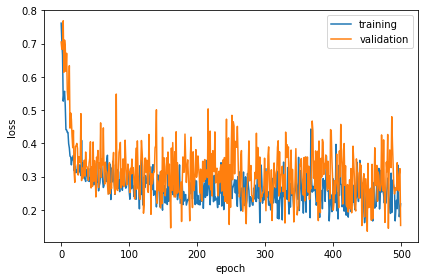

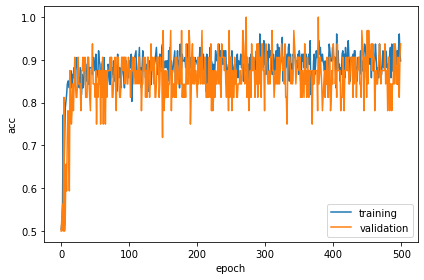

{'n_train': 127, 'n_val': 32, 'n_test': 40}
40
[1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


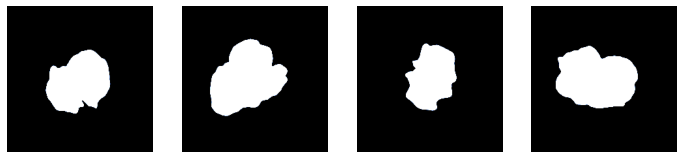

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0221, -0.0190, -0.0144,  ...,  0.0074,  0.0109, -0.0048],
        [-0.0006,  0.0167, -0.0129,  ...,  0.0098, -0.0018,  0.0059]],
       requires_grad=True), Parameter containing:
tensor([0.0034, 0.0128], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7000 Acc: 0.5433
val Loss: 0.7038 Acc: 0.4688

Epoch 10/499
----------
train Loss: 0.3837 Acc: 0.8583
val Loss: 0.4536 Acc: 0.8438

Epoch 20/499
----------
train Loss: 0.3420 Acc: 0.8819
val Loss: 0.3425 Acc: 0.7812

Epoch 30/499
----------
train Loss: 0.3578 Acc: 0.8346
val Loss: 0.3220 Acc: 0.8438

Epoch 40/499
----------
train Loss: 0.3092 Acc: 0.9134
val Loss: 0.3299 Acc: 0.8438

Epoch 50/499
----------
train Loss: 0.3186 Acc: 0.8661
val Loss: 0.3857 Acc: 0.7812

Epoch 60/499
----------
train Loss: 0.3499 Acc: 0.8189
val Loss: 0.2709 Acc: 0.9062

Epoch 70/499
----------
train Loss: 0.3109 Acc: 0.8740
val Loss: 0.3224 Acc: 0.8438

Epoch 80/499
----------
train Loss: 0.3249

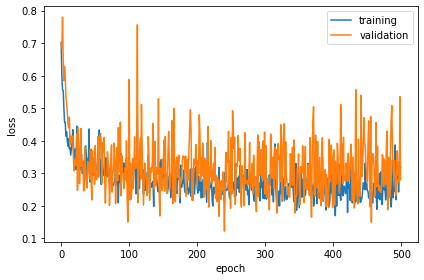

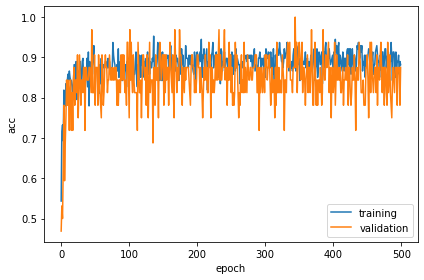

{'n_train': 127, 'n_val': 32, 'n_test': 40}
40
[1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0
 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


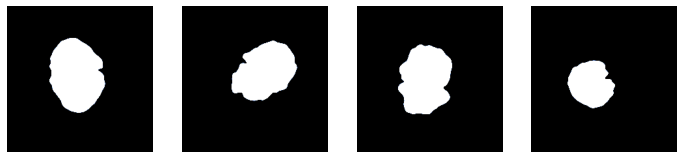

['weight', 'bias']
[Parameter containing:
tensor([[-0.0180,  0.0196, -0.0217,  ..., -0.0115,  0.0013, -0.0020],
        [-0.0092,  0.0199,  0.0121,  ...,  0.0141,  0.0062,  0.0096]],
       requires_grad=True), Parameter containing:
tensor([0.0148, 0.0064], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7879 Acc: 0.5118
val Loss: 0.7444 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.4528 Acc: 0.8031
val Loss: 0.5664 Acc: 0.6875

Epoch 20/499
----------
train Loss: 0.3855 Acc: 0.8346
val Loss: 0.4097 Acc: 0.8750

Epoch 30/499
----------
train Loss: 0.2995 Acc: 0.8976
val Loss: 0.4003 Acc: 0.8750

Epoch 40/499
----------
train Loss: 0.3467 Acc: 0.8346
val Loss: 0.3694 Acc: 0.8125

Epoch 50/499
----------
train Loss: 0.3149 Acc: 0.8819
val Loss: 0.3678 Acc: 0.8438

Epoch 60/499
----------
train Loss: 0.2961 Acc: 0.8898
val Loss: 0.3870 Acc: 0.7812

Epoch 70/499
----------
train Loss: 0.2800 Acc: 0.8898
val Loss: 0.2659 Acc: 0.8438

Epoch 80/499
----------
train Loss: 0.3741

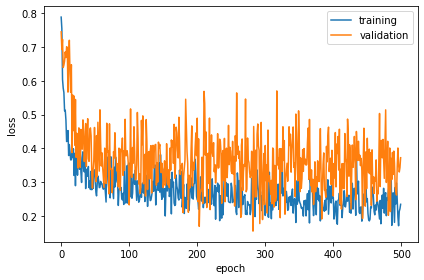

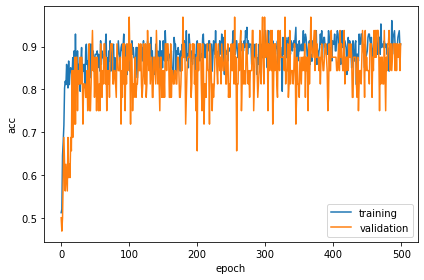

{'n_train': 127, 'n_val': 32, 'n_test': 40}
40
[0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1
 1 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


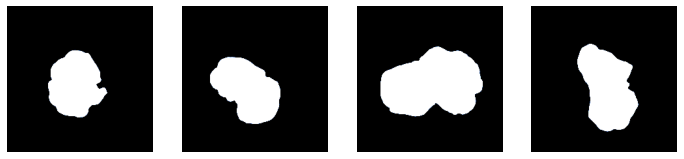

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0010,  0.0165,  0.0064,  ..., -0.0003,  0.0067, -0.0219],
        [-0.0096, -0.0061, -0.0169,  ...,  0.0183, -0.0072,  0.0152]],
       requires_grad=True), Parameter containing:
tensor([0.0119, 0.0213], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7857 Acc: 0.4724
val Loss: 0.8732 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.4175 Acc: 0.8268
val Loss: 0.5777 Acc: 0.6875

Epoch 20/499
----------
train Loss: 0.3812 Acc: 0.8268
val Loss: 0.3520 Acc: 0.9062

Epoch 30/499
----------
train Loss: 0.3398 Acc: 0.8898
val Loss: 0.4149 Acc: 0.8125

Epoch 40/499
----------
train Loss: 0.3662 Acc: 0.8189
val Loss: 0.4482 Acc: 0.8438

Epoch 50/499
----------
train Loss: 0.3251 Acc: 0.8346
val Loss: 0.3532 Acc: 0.8438

Epoch 60/499
----------
train Loss: 0.3328 Acc: 0.8819
val Loss: 0.3565 Acc: 0.8750

Epoch 70/499
----------
train Loss: 0.2975 Acc: 0.8819
val Loss: 0.3630 Acc: 0.8125

Epoch 80/499
----------
train Loss: 0.3576

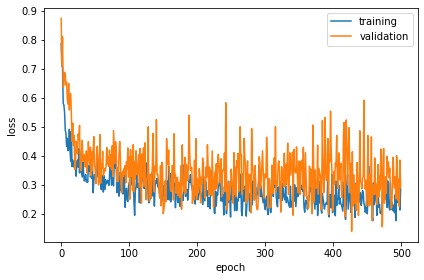

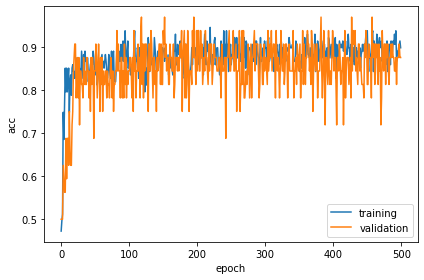

{'n_train': 127, 'n_val': 32, 'n_test': 40}
40
[1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0
 0 1 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


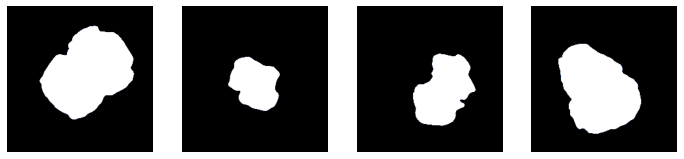

['weight', 'bias']
[Parameter containing:
tensor([[-0.0138,  0.0186,  0.0153,  ..., -0.0139,  0.0096, -0.0016],
        [ 0.0068, -0.0047,  0.0217,  ..., -0.0045, -0.0126,  0.0191]],
       requires_grad=True), Parameter containing:
tensor([0.0139, 0.0158], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.8590 Acc: 0.4961
val Loss: 0.7992 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.4532 Acc: 0.8268
val Loss: 0.6431 Acc: 0.5625

Epoch 20/499
----------
train Loss: 0.4071 Acc: 0.8110
val Loss: 0.4042 Acc: 0.7812

Epoch 30/499
----------
train Loss: 0.3480 Acc: 0.8819
val Loss: 0.3776 Acc: 0.8438

Epoch 40/499
----------
train Loss: 0.3324 Acc: 0.8819
val Loss: 0.3030 Acc: 0.8750

Epoch 50/499
----------
train Loss: 0.2990 Acc: 0.8661
val Loss: 0.4981 Acc: 0.8125

Epoch 60/499
----------
train Loss: 0.3652 Acc: 0.8346
val Loss: 0.4637 Acc: 0.8125

Epoch 70/499
----------
train Loss: 0.3592 Acc: 0.8583
val Loss: 0.2980 Acc: 0.9062

Epoch 80/499
----------
train Loss: 0.3594

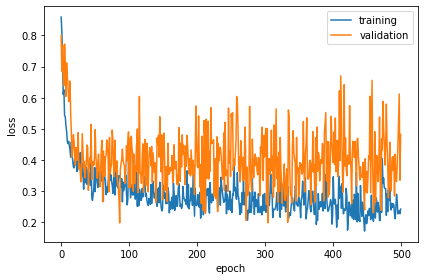

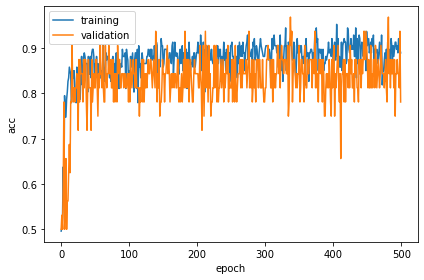

{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/RIL5/0d'}
Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/data_mask/RIL5/0d
{'RIL5_0d_F': 0, 'RIL5_0d_M': 1}
{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0
 1 1 1 1 0 1 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


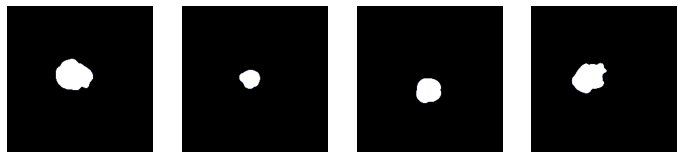

['weight', 'bias']
[Parameter containing:
tensor([[-0.0064, -0.0198,  0.0138,  ...,  0.0050,  0.0181,  0.0086],
        [-0.0155, -0.0200, -0.0028,  ..., -0.0136, -0.0152,  0.0041]],
       requires_grad=True), Parameter containing:
tensor([-0.0156,  0.0047], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7965 Acc: 0.5156
val Loss: 0.7538 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6797 Acc: 0.6042
val Loss: 0.7301 Acc: 0.4896

Epoch 20/499
----------
train Loss: 0.7274 Acc: 0.5104
val Loss: 0.7129 Acc: 0.5521

Epoch 30/499
----------
train Loss: 0.6642 Acc: 0.5990
val Loss: 0.6855 Acc: 0.5208

Epoch 40/499
----------
train Loss: 0.7035 Acc: 0.5599
val Loss: 0.7459 Acc: 0.5417

Epoch 50/499
----------
train Loss: 0.7338 Acc: 0.5365
val Loss: 0.7629 Acc: 0.5521

Epoch 60/499
----------
train Loss: 0.7537 Acc: 0.5417
val Loss: 0.8547 Acc: 0.5312

Epoch 70/499
----------
train Loss: 0.7548 Acc: 0.5521
val Loss: 0.6840 Acc: 0.5625

Epoch 80/499
----------
train Loss: 0.68

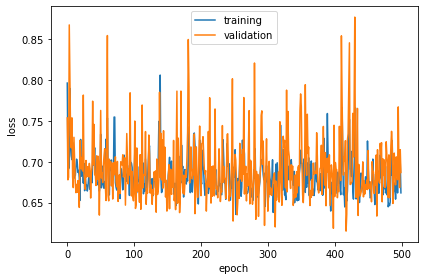

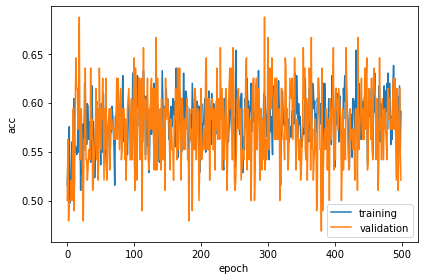

{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1
 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1
 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0
 0 0 1 0 1 0 0 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


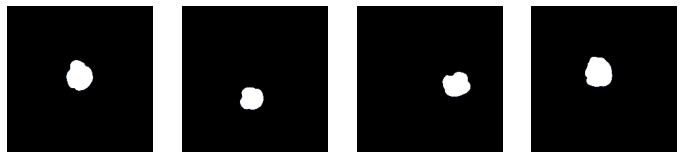

['weight', 'bias']
[Parameter containing:
tensor([[-0.0060, -0.0039,  0.0006,  ..., -0.0013, -0.0032, -0.0181],
        [ 0.0092, -0.0081,  0.0218,  ...,  0.0035,  0.0055,  0.0037]],
       requires_grad=True), Parameter containing:
tensor([-0.0130,  0.0087], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7063 Acc: 0.5234
val Loss: 0.7218 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.7122 Acc: 0.5365
val Loss: 0.6589 Acc: 0.6146

Epoch 20/499
----------
train Loss: 0.7205 Acc: 0.5755
val Loss: 0.7339 Acc: 0.5312

Epoch 30/499
----------
train Loss: 0.6862 Acc: 0.5495
val Loss: 0.6722 Acc: 0.6250

Epoch 40/499
----------
train Loss: 0.7020 Acc: 0.5495
val Loss: 0.6785 Acc: 0.5938

Epoch 50/499
----------
train Loss: 0.7674 Acc: 0.5234
val Loss: 0.7241 Acc: 0.5000

Epoch 60/499
----------
train Loss: 0.6669 Acc: 0.5911
val Loss: 0.6594 Acc: 0.5729

Epoch 70/499
----------
train Loss: 0.7241 Acc: 0.5365
val Loss: 0.6832 Acc: 0.5729

Epoch 80/499
----------
train Loss: 0.68

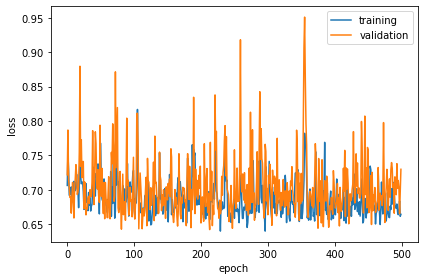

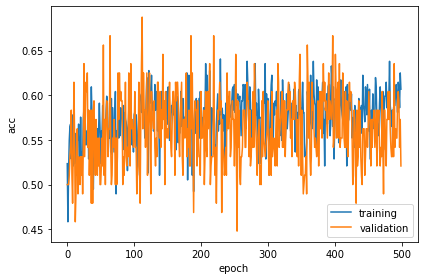

{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1
 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1
 0 0 0 1 0 1 0 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


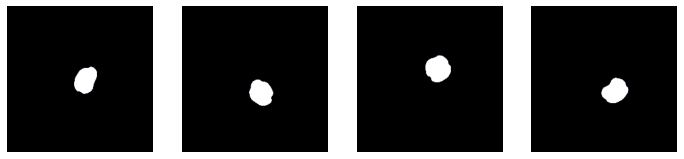

['weight', 'bias']
[Parameter containing:
tensor([[-0.0199,  0.0033, -0.0121,  ..., -0.0015,  0.0085,  0.0055],
        [ 0.0002, -0.0194,  0.0013,  ...,  0.0145, -0.0197, -0.0207]],
       requires_grad=True), Parameter containing:
tensor([0.0055, 0.0025], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7490 Acc: 0.4792
val Loss: 0.6953 Acc: 0.4792

Epoch 10/499
----------
train Loss: 0.7096 Acc: 0.5391
val Loss: 0.7486 Acc: 0.4896

Epoch 20/499
----------
train Loss: 0.7417 Acc: 0.5286
val Loss: 0.7267 Acc: 0.5104

Epoch 30/499
----------
train Loss: 0.7160 Acc: 0.6016
val Loss: 0.6713 Acc: 0.6042

Epoch 40/499
----------
train Loss: 0.6713 Acc: 0.6016
val Loss: 0.6496 Acc: 0.5833

Epoch 50/499
----------
train Loss: 0.7174 Acc: 0.5339
val Loss: 0.6564 Acc: 0.6146

Epoch 60/499
----------
train Loss: 0.6901 Acc: 0.5651
val Loss: 0.7134 Acc: 0.5104

Epoch 70/499
----------
train Loss: 0.6922 Acc: 0.5469
val Loss: 0.7295 Acc: 0.5521

Epoch 80/499
----------
train Loss: 0.6988

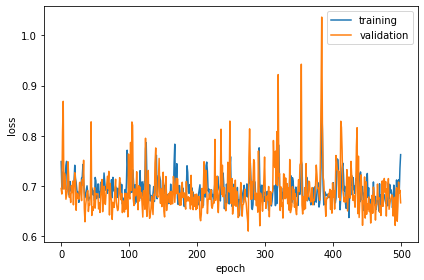

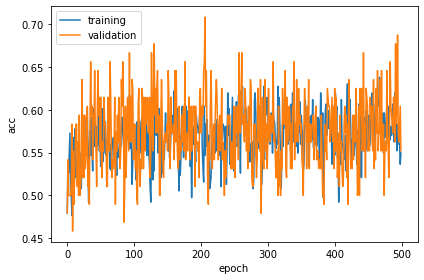

{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 1 1 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


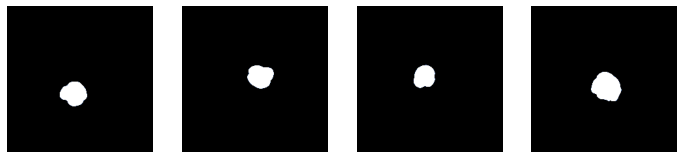

['weight', 'bias']
[Parameter containing:
tensor([[-6.6682e-05, -6.7480e-03, -1.0853e-02,  ...,  1.0779e-02,
         -2.1147e-02,  1.0710e-03],
        [ 1.5961e-02,  7.4756e-03,  1.5477e-02,  ...,  1.3540e-02,
          2.0219e-02,  2.7489e-03]], requires_grad=True), Parameter containing:
tensor([-0.0086, -0.0174], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7458 Acc: 0.4974
val Loss: 0.7121 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.7099 Acc: 0.5911
val Loss: 0.7093 Acc: 0.5417

Epoch 20/499
----------
train Loss: 0.6912 Acc: 0.5573
val Loss: 0.6939 Acc: 0.5000

Epoch 30/499
----------
train Loss: 0.7263 Acc: 0.5547
val Loss: 0.6819 Acc: 0.5312

Epoch 40/499
----------
train Loss: 0.6887 Acc: 0.5677
val Loss: 0.6789 Acc: 0.5312

Epoch 50/499
----------
train Loss: 0.6867 Acc: 0.5573
val Loss: 0.7343 Acc: 0.5208

Epoch 60/499
----------
train Loss: 0.6578 Acc: 0.5990
val Loss: 0.6967 Acc: 0.5729

Epoch 70/499
----------
train Loss: 0.7143 Acc: 0.5443
val Loss: 0

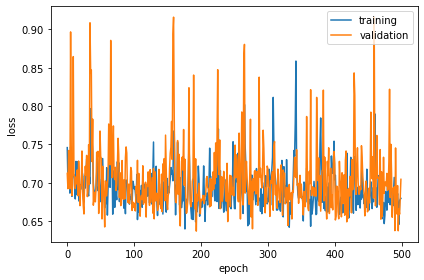

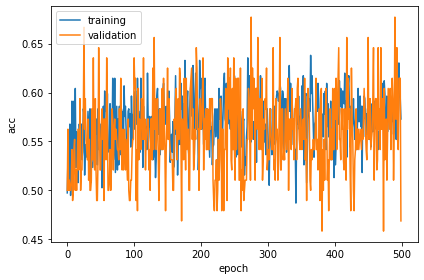

{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1
 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1
 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1
 0 0 1 1 1 1 0 0 0]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


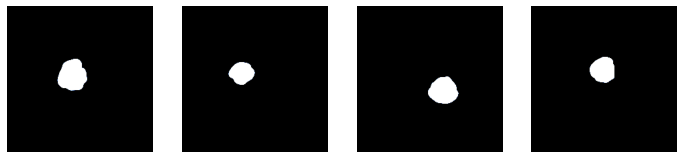

['weight', 'bias']
[Parameter containing:
tensor([[-0.0118, -0.0076, -0.0061,  ..., -0.0196,  0.0030,  0.0023],
        [-0.0118, -0.0167, -0.0048,  ...,  0.0025, -0.0083, -0.0051]],
       requires_grad=True), Parameter containing:
tensor([0.0071, 0.0133], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.8162 Acc: 0.4740
val Loss: 0.7003 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6960 Acc: 0.5339
val Loss: 0.6894 Acc: 0.5312

Epoch 20/499
----------
train Loss: 0.7083 Acc: 0.5469
val Loss: 0.7170 Acc: 0.5312

Epoch 30/499
----------
train Loss: 0.6847 Acc: 0.5859
val Loss: 0.7363 Acc: 0.4792

Epoch 40/499
----------
train Loss: 0.6821 Acc: 0.5703
val Loss: 0.7204 Acc: 0.4896

Epoch 50/499
----------
train Loss: 0.6990 Acc: 0.5391
val Loss: 0.7191 Acc: 0.5208

Epoch 60/499
----------
train Loss: 0.7263 Acc: 0.5599
val Loss: 0.7901 Acc: 0.5000

Epoch 70/499
----------
train Loss: 0.6987 Acc: 0.5417
val Loss: 0.7271 Acc: 0.5104

Epoch 80/499
----------
train Loss: 0.6795

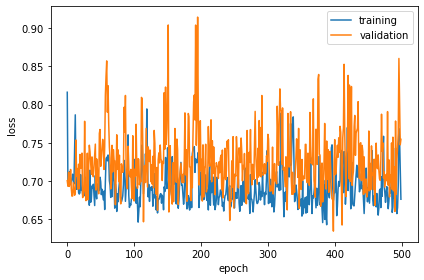

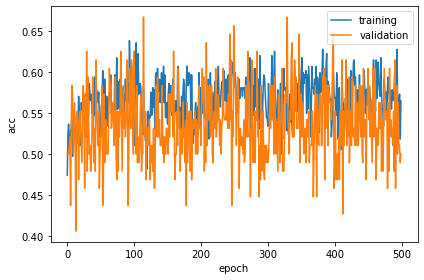

{'size_image': 224, 'batch_size': 32, 'root': './data/data_mask/RIL5/1d'}
Dataset ImageFolder
    Number of datapoints: 600
    Root location: ./data/data_mask/RIL5/1d
{'RIL5_1d_F': 0, 'RIL5_1d_M': 1}
{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0
 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0
 1 1 1 1 0 1 1 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


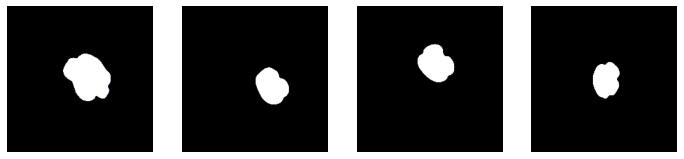

['weight', 'bias']
[Parameter containing:
tensor([[-0.0086, -0.0110,  0.0217,  ...,  0.0142, -0.0003, -0.0103],
        [ 0.0127,  0.0031, -0.0156,  ...,  0.0129,  0.0043,  0.0040]],
       requires_grad=True), Parameter containing:
tensor([-0.0107, -0.0087], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7464 Acc: 0.4766
val Loss: 0.6988 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.7548 Acc: 0.5365
val Loss: 0.7259 Acc: 0.5208

Epoch 20/499
----------
train Loss: 0.6750 Acc: 0.5938
val Loss: 0.7244 Acc: 0.4896

Epoch 30/499
----------
train Loss: 0.6940 Acc: 0.5573
val Loss: 0.7421 Acc: 0.5417

Epoch 40/499
----------
train Loss: 0.7125 Acc: 0.5625
val Loss: 0.7206 Acc: 0.4583

Epoch 50/499
----------
train Loss: 0.6838 Acc: 0.5703
val Loss: 0.7315 Acc: 0.5312

Epoch 60/499
----------
train Loss: 0.7074 Acc: 0.5599
val Loss: 0.7882 Acc: 0.5104

Epoch 70/499
----------
train Loss: 0.6583 Acc: 0.6042
val Loss: 0.7308 Acc: 0.5417

Epoch 80/499
----------
train Loss: 0.70

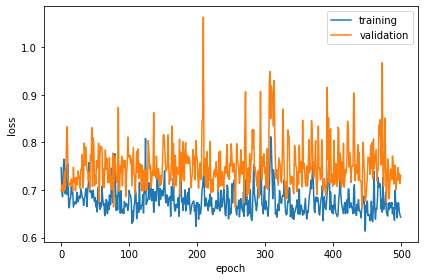

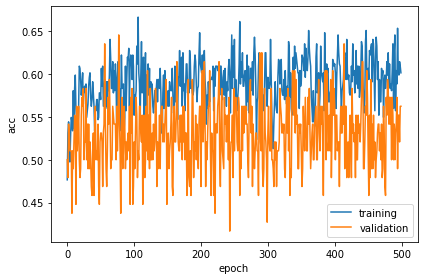

{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 1
 1 0 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1
 1 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0
 0 0 1 0 1 0 0 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


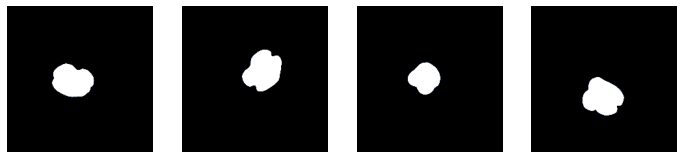

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0196, -0.0138,  0.0126,  ..., -0.0154, -0.0082,  0.0192],
        [ 0.0065, -0.0174, -0.0018,  ..., -0.0034, -0.0034,  0.0079]],
       requires_grad=True), Parameter containing:
tensor([0.0051, 0.0199], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7502 Acc: 0.4505
val Loss: 0.7199 Acc: 0.4167

Epoch 10/499
----------
train Loss: 0.7348 Acc: 0.5286
val Loss: 0.7139 Acc: 0.5000

Epoch 20/499
----------
train Loss: 0.6475 Acc: 0.6068
val Loss: 0.7634 Acc: 0.5208

Epoch 30/499
----------
train Loss: 0.6699 Acc: 0.5807
val Loss: 0.7194 Acc: 0.5104

Epoch 40/499
----------
train Loss: 0.6721 Acc: 0.5964
val Loss: 0.7655 Acc: 0.5208

Epoch 50/499
----------
train Loss: 0.6850 Acc: 0.5729
val Loss: 0.6850 Acc: 0.5208

Epoch 60/499
----------
train Loss: 0.6788 Acc: 0.5755
val Loss: 0.7043 Acc: 0.5000

Epoch 70/499
----------
train Loss: 0.6665 Acc: 0.5885
val Loss: 0.6612 Acc: 0.6146

Epoch 80/499
----------
train Loss: 0.6906

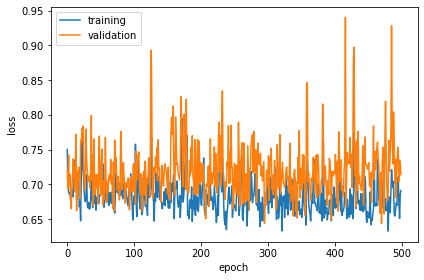

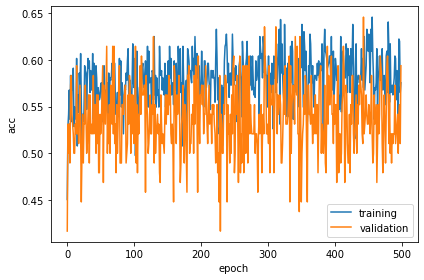

{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1
 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1
 0 0 0 1 0 1 0 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


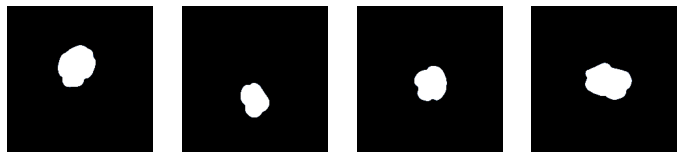

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0197,  0.0197, -0.0197,  ...,  0.0131, -0.0198,  0.0117],
        [-0.0146,  0.0015,  0.0111,  ...,  0.0011, -0.0036, -0.0200]],
       requires_grad=True), Parameter containing:
tensor([-0.0203,  0.0032], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7941 Acc: 0.4740
val Loss: 0.7111 Acc: 0.4896

Epoch 10/499
----------
train Loss: 0.7171 Acc: 0.5026
val Loss: 0.6733 Acc: 0.6562

Epoch 20/499
----------
train Loss: 0.6829 Acc: 0.5703
val Loss: 0.6642 Acc: 0.6146

Epoch 30/499
----------
train Loss: 0.7001 Acc: 0.5417
val Loss: 0.6721 Acc: 0.5625

Epoch 40/499
----------
train Loss: 0.6661 Acc: 0.5938
val Loss: 0.7015 Acc: 0.4792

Epoch 50/499
----------
train Loss: 0.6784 Acc: 0.5495
val Loss: 0.7066 Acc: 0.5417

Epoch 60/499
----------
train Loss: 0.7659 Acc: 0.5156
val Loss: 0.7488 Acc: 0.5104

Epoch 70/499
----------
train Loss: 0.7024 Acc: 0.5260
val Loss: 0.6990 Acc: 0.5417

Epoch 80/499
----------
train Loss: 0.69

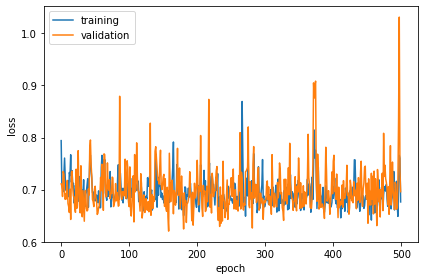

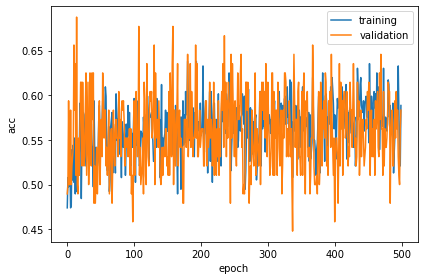

{'n_train': 384, 'n_val': 96, 'n_test': 120}
120
[1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 1 1 0 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


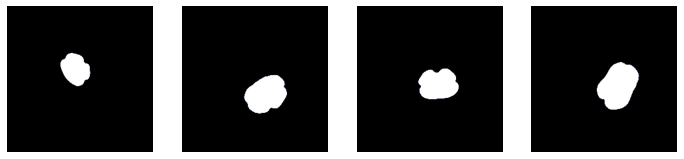

['weight', 'bias']
[Parameter containing:
tensor([[ 0.0080,  0.0051, -0.0116,  ...,  0.0136,  0.0095, -0.0088],
        [-0.0188,  0.0036, -0.0162,  ...,  0.0140,  0.0086,  0.0174]],
       requires_grad=True), Parameter containing:
tensor([ 0.0040, -0.0073], requires_grad=True)]
Epoch 0/499
----------
train Loss: 0.7546 Acc: 0.4844
val Loss: 0.7259 Acc: 0.5000

Epoch 10/499
----------
train Loss: 0.6995 Acc: 0.5365
val Loss: 0.6731 Acc: 0.6042

Epoch 20/499
----------
train Loss: 0.6722 Acc: 0.5625
val Loss: 0.6803 Acc: 0.5833

Epoch 30/499
----------
train Loss: 0.7453 Acc: 0.5182
val Loss: 0.6823 Acc: 0.5521

Epoch 40/499
----------
train Loss: 0.6746 Acc: 0.5521
val Loss: 0.7075 Acc: 0.5833

Epoch 50/499
----------
train Loss: 0.6845 Acc: 0.5781
val Loss: 0.7064 Acc: 0.4792

Epoch 60/499
----------
train Loss: 0.7129 Acc: 0.5599
val Loss: 0.8708 Acc: 0.4896

Epoch 70/499
----------
train Loss: 0.6812 Acc: 0.5859
val Loss: 0.7167 Acc: 0.5729

Epoch 80/499
----------
train Loss: 0.72

In [ ]:
strains = ['Aus', 'RIL5', 'Tak']
days = ['0d', '1d', '2d', '3d', '4d', '7d']
results_dname = 'results_forGitHub'
makedirs(results_dname)
ablations = ['binary']
train_rotated = True

args = Args()
for ablation in ablations:
  for strain in strains:
    for day in days:
      args.root = './data/data_' + ablation + '/' + strain + '/' + day
      print(args.__dict__)

      Transform = ImageTransform(fill=0)
      full_dataset = ImageFolder(root=args.root)
      print(full_dataset)
      print(full_dataset.class_to_idx)

      for seed in range(5):
        train_loader, val_loader, test_loader, dataset_attributes, dataset_indices = get_data_rotatedTestset(args, full_dataset, Transform, MarchantiaDataset, seed=seed)
        print(dataset_attributes)
        print(len(test_loader.dataset))
        targets, train_indices, val_indices, test_indices = dataset_indices['targets'], dataset_indices['idx_train'], dataset_indices['idx_val'], dataset_indices['idx_test']
        print(targets[test_indices])
        dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

        train_images, _ = next(iter(train_loader))
        visualize_batch(train_images); plt.show()

        model = resnet50(pretrained=True)
        set_requires_grad_toFalse(model) ## requires_grad=False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2) ## requires_grad=True only in overwritten parameters
        print([name for name, _ in model.fc.named_parameters()])
        print([param for param in model.fc.parameters()])
        model.to(dev)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
        model, train_losses, train_accs, val_losses, val_accs = train_model_pytorch_tutorial(model, dataloaders, dev, criterion, optimizer, num_epochs=500)
        print(np.argmax(val_accs))
        _, val_acc = compute_loss(model, val_loader, dev)
        print('val_acc: ', val_acc)
        test_loss, test_acc = compute_loss(model, test_loader, dev)
        print('test acc', test_acc)

        ## save
        dt_now = get_datetime()
        print(args.root.split('/')[-2] + args.root.split('/')[-1])
        strain_day = args.root.split('/')[-2] + '_' + args.root.split('/')[-1]
        ablation_save = ablation + '-rotated' if train_rotated == True else ablation
        results_path = results_dname + '/' + dt_now + '_' + strain_day + '_' + ablation_save  + '/'
        makedirs(results_path)

        ## .txt to save seed & epoch with max validation accuracy
        f = open(results_path + 'model_stats.txt', 'w')
        f.write('seed : ' + str(seed) + '\n')
        f.write('epoch with max val. acc. : ' + str(np.argmax(val_accs)) + '\n')
        f.close()

        figtype = 'learning_trajectory_'
        plot_learning_trajectory(train_losses, val_losses); plt.savefig(results_path + figtype + 'loss.png'); plt.show()
        plot_learning_trajectory(train_accs, val_accs, ylabel='acc'); plt.savefig(results_path + figtype + 'acc.png'); plt.show()

        save_model_results(results_path, dt_now, model, train_losses, train_accs, val_losses, val_accs, test_loss, test_acc)
        save_data_indices(results_path, train_indices, val_indices, test_indices)